## Duffing oscillator

In [25]:
# Imports
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
jax.config.update('jax_enable_x64',True)
from evaluation_metrics import get_nrmse
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

We consider the IVP

$$
u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0 
$$

where $\alpha = -3$, $\beta = 3$, $\delta = 0.2$, $\gamma = 1$ and $\omega = 2$.


Equivalently, if we introduce the variables $x_0 = u$, and $x_1 = u'$ we can re-write the IVP as a system of two first-order ODEs

$$
\frac{d \mathbf{x}}{dt} =
\frac{d}{dt}
\begin{bmatrix}
x_0 \\
x_1
\end{bmatrix} =  
\begin{bmatrix}
x_1 \\
-\alpha x_0 - \beta x_0^3 - \delta x_1 + \gamma \cos(\omega t)
\end{bmatrix}\qquad x_0(0) = 0, x_1(0) = 0
$$


In [2]:
# Define the constants
alpha = -3.
beta = 3.
delta = 0.2
gamma = 1.
omega = 2

# Define forcing term
def forcing(t):
    return gamma*jnp.cos(omega*t)

# Define the Duffing RHS
@eqx.filter_jit
def duffing(t,x, args):
    return jnp.array([
        x[1],
        - alpha * x[0] - beta * x[0]**3 - delta * x[1] + forcing(t)
    ])

In [3]:
def show_term(c,neg = False):
    if neg is True:
        c = -c
    if c>0:
        return f"+{c}"
    elif c<0:
        return f"-{jnp.abs(c)}"
    else:
        return "0"
print(f"x''(t) = u(t) {show_term(beta,neg = True)} x(t)^3 {show_term(alpha,neg = True)} x(t) {show_term(delta,neg = True)} x'(t) \n u(t) = {gamma} cos({omega}t)")
print(f"")

x''(t) = u(t) -3.0 x(t)^3 +3.0 x(t) -0.2 x'(t) 
 u(t) = 1.0 cos(2t)



We use ```diffrax``` to solve numerically the ODE system

In [4]:
# Initial time
t0 = 0.
# Final time
t1 = 50.
# Define the RHS of the system
term = ODETerm(duffing)
# Pick a solver
solver = Dopri5()
# Save dense output, that can later be evaluated at any point inside [t0,t1]
saveat = SaveAt(dense=True)
# Size control: Adapts the step size to produce a solution accurate to a given tolerance
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
# Initial condition
y0 = jnp.zeros(2)
# Solve
ode_sol = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 5000
    )

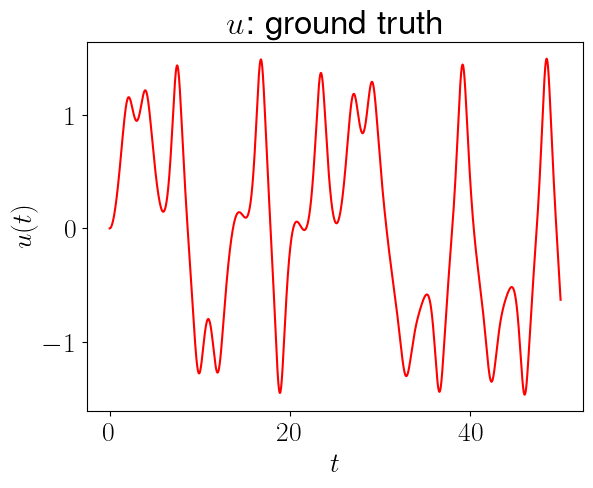

In [5]:
# Fine grid
tvals = jnp.linspace(t0,t1,5000)
# Fine grid values
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.title('$u$: ground truth')
plt.plot(tvals,y_full[:,0], c = 'red')
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
# plt.plot(tvals,y_full[:,1],label = "u'(t)")
plt.show()

# Get the data for the problem

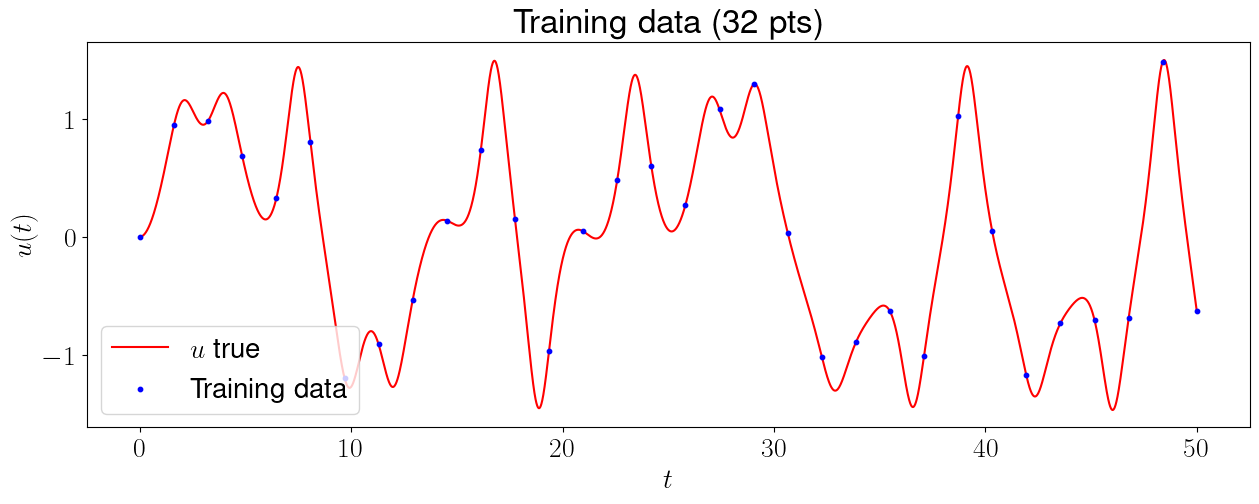

In [6]:
plt.figure(figsize=(15,5))
# Fine grid
tvals = jnp.linspace(t0,t1,5000)
# u(Fine grid)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0], c = 'red', zorder=0, label = '$u$ true')
# X_obs
num_obs = 32 
obs_times = jnp.linspace(t0,t1,num_obs)
# u(X_obs)
u_obs = jax.vmap(ode_sol.evaluate)(obs_times)[:,0]
plt.scatter(obs_times,u_obs, s=10,c= 'blue', zorder=1, label = 'Training data')
plt.title(f'Training data ({num_obs} pts)')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')
plt.legend(loc = 'lower left')
plt.show()

In [7]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,jacrev
import numpy as np
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
t_obs = obs_times.reshape(-1,1)

## Train the 1 step and 2 step method

In [9]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_gaussianRBF,
    get_rq_kernel
)
from EquationModel import CholInducedRKHS, OperatorPDEModel,InducedOperatorModel
from functools import partial
from Kernels import log1pexp,inv_log1pexp

def dtt_k(k,index = 0):
    return dt_k(dt_k(k,index),index)

u_operators = (eval_k,dt_k,dtt_k)

feature_operators = (eval_k,dt_k)

k_u = get_rq_kernel(1.)
num_colloc = 1000
t_grid = jnp.linspace(t0,t1,num_colloc).reshape(-1,1)


u_model = CholInducedRKHS(
    t_grid,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(t_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,t_grid,u_params_init))
    .reshape(
            len(t_grid),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([t_grid,grid_features_init])

num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))

k_P_u_part = get_gaussianRBF(1.)
def k_P(x,y):
    return k_P_u_part(x[1:],y[1:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (t_obs,),
    (u_obs,),
    (t_grid,),
    feature_operators,
    rhs_operator=dtt_k,
    datafit_weight = 50,
    rhs_forcing_values = (-forcing(t_grid)[:,0],),
    num_P_operator_params = 500
)

utt_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])-forcing(t_grid)[:,0]
P_params_init = P_model.get_fitted_params(grid_features_init,utt_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

In [10]:
from Optimizers import CholeskyLM,LMParams

In [11]:
optParams = LMParams(max_iter = 1001,min_alpha = 1e-9)
sol,conv = CholeskyLM(params_init,EqnModel,1e-9,optParams = optParams)

  0%|          | 4/1001 [00:19<1:02:16,  3.75s/it]

Iteration 0, loss = 0.2444, gradnorm = 0.3043, alpha = 2.5, improvement_ratio = 0.9996
Iteration 1, loss = 0.2243, gradnorm = 0.2501, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.2052, gradnorm = 0.2176, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.1866, gradnorm = 0.1945, alpha = 1.447, improvement_ratio = 1.001
Iteration 4, loss = 0.1687, gradnorm = 0.1752, alpha = 1.206, improvement_ratio = 1.001
Iteration 5, loss = 0.1515, gradnorm = 0.1573, alpha = 1.005, improvement_ratio = 1.002


  5%|▌         | 55/1001 [00:21<00:40, 23.60it/s] 

Iteration 50, loss = 0.00648, gradnorm = 0.004524, alpha = 0.002307, improvement_ratio = 0.151


 11%|█         | 106/1001 [00:23<00:32, 27.82it/s]

Iteration 100, loss = 0.004488, gradnorm = 0.007102, alpha = 0.002307, improvement_ratio = 0.2453


 15%|█▌        | 154/1001 [00:25<00:29, 28.90it/s]

Iteration 150, loss = 0.0006422, gradnorm = 0.0004048, alpha = 8.099e-06, improvement_ratio = 1.029


 20%|██        | 205/1001 [00:26<00:28, 28.01it/s]

Iteration 200, loss = 1.031e-06, gradnorm = 8.177e-05, alpha = 7.935e-09, improvement_ratio = 0.799


 22%|██▏       | 225/1001 [00:27<01:35,  8.14it/s]


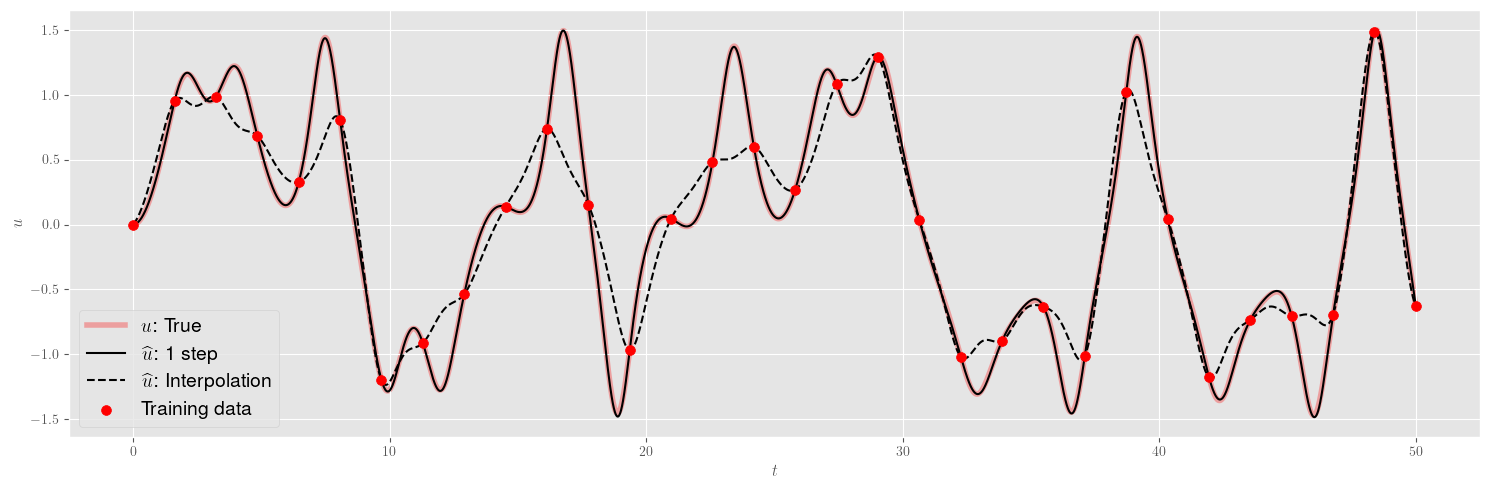

In [12]:
# u predictions
plt.figure(figsize=(15,5))
# u true
true = y_full[:,0]
plt.plot(tvals,true,label = '$u$: True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# 1 step u pred
pred1 = u_model.point_evaluate(tvals,EqnModel.get_u_params(sol)[0])
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,pred1,c = 'black',ls ='solid',label = r'$\widehat{u}$: 1 step', zorder=1)
# 2 step u predv
pred2 = u_model.point_evaluate(tvals,u_params_init)
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'$\widehat{u}$: Interpolation',ls = 'dashed', c= 'black', zorder=2)
# Training data
plt.scatter(obs_times,u_obs, s=50, zorder=3, c="red", label='Training data')
# Plot configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}) and Interpolation (err: {round(err_2,4)}) methods')
plt.xlabel('$t$')
plt.ylabel('$u$')
plt.legend(fontsize = 14, loc = 'lower left')
plt.tight_layout()
plt.savefig('u_filtering_and_data.pdf',
            dpi=300,
            format ="pdf"
            )
plt.show()

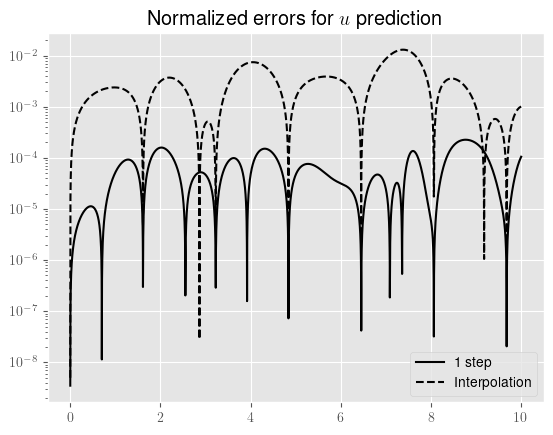

In [23]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_sol.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = u_model.point_evaluate(tvals,EqnModel.get_u_params(sol)[0])
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='solid')
# 2 step method
pred_2_step = u_model.point_evaluate(tvals,u_params_init)
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = 'Interpolation', c = 'black', ls= 'dashed')
# Plot configs
plt.title('Normalized errors for $u$ prediction')
plt.yscale('log')
plt.legend()
plt.show()

In [28]:
# Filtering error
for final in [10,30,50]:
    # Domain
    t_values = np.linspace(0,final,5000)
    # True
    true_values = jax.vmap(ode_sol.evaluate)(t_values)[:,0]
    # 1-step
    pred_values_1step = u_model.point_evaluate(t_values,EqnModel.get_u_params(sol)[0])
    # Interp
    pred_values_interp = u_model.point_evaluate(t_values,u_params_init)
    
    # Print errors
    print(f'Error 1step in [0,{final}]: ', get_nrmse(true_values, pred_values_1step))
    print(f'Error interp in [0,{final}]: ', get_nrmse(true_values, pred_values_interp))

Error 1step in [0,10]:  0.005991516437857737
Error interp in [0,10]:  0.30735732507473634
Error 1step in [0,30]:  0.008074816415734092
Error interp in [0,30]:  0.3975087541048149
Error 1step in [0,50]:  0.009656958322781873
Error interp in [0,50]:  0.3462545648125041


## How well perform $\widehat{P}$ learned from 1 step and 2 step methods ?

Let's compute the simulated trajectories starting at a different initial condition from:

1. $u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

2. $u'' = \widehat{P}_{1step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

3. $u'' = \widehat{P}_{2step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

In [15]:
# Learned parameters for 1-step
fitted_P_params = EqnModel.get_P_params(sol)
# Phat 1-step method
def learned_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,fitted_P_params)[0] + forcing(t)])
# Phat 2-step method
def init_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,P_params_init)[0] + forcing(t)])

In [16]:
# New initial condition
# y0 = jnp.array([0.,0.5]) works
# y0 = jnp.array([0.,0.2]) works
# y0 = jnp.array([0.,1]) works
y0 = jnp.array([0.,-1])

In [17]:
# P
term = ODETerm(duffing)
# Phat from 1 step
fitted_term = ODETerm(learned_vf)
# Phat from 2 step
init_term = ODETerm(init_vf)

# Simulate between
t0,t1 = 0,10 

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

In [18]:
# SINDy
feature_operators_SINDy = (eval_k,dt_k,dtt_k)

S = (u_model.evaluate_operators(feature_operators_SINDy,t_grid,u_params_init).reshape(
            len(t_grid), 
            len(feature_operators_SINDy),
            order = 'F'
                ))
# Constant
CONST = jnp.ones(len(S[:,0]))
# First degree
U = S[:,0]
U_t = S[:,1]
# Second degree
UU = jnp.multiply(S[:,0],S[:,0])
UU_t = jnp.multiply(S[:,0],S[:,1])
U_tU_t = jnp.multiply(S[:,1],S[:,1])
# Third degree
UUU = jnp.multiply(S[:,0],UU)
UUU_t = jnp.multiply(UU,S[:,1])
UU_tU_t = jnp.multiply(S[:,0],U_tU_t)
U_tU_tU_t = jnp.multiply(S[:,1],U_tU_t)

# Forcing values feature
F = forcing(t_grid)

# Build dictionary
Theta = jnp.vstack([CONST, 
                    U,U_t, 
                    UU,UU_t,U_tU_t,
                    UUU,UUU_t,UU_tU_t,U_tU_tU_t,
                    F[:,0]]).T
# LHS: Assume it is u_ddot
U_tt = S[:,2]

# Threshold algorithm
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi
   
# Run SINDY
coeffs_SINDy = sparsifyDynamics(Theta,U_tt.reshape(-1,1),lamb = 1e-2, n = 1)
coeffs_SINDy = jnp.array(coeffs_SINDy[:,0])
print(coeffs_SINDy)

# Phat from SINDy
@eqx.filter_jit
def Phat_SINDy(t,x, args):
    return jnp.array([
        x[1], jnp.dot(coeffs_SINDy, 
                      jnp.array([1.,
                          x[0],
                          x[1],
                          x[0]**2,
                          x[0] * x[1],
                          x[1]**2,
                          x[0]**3,
                          x[0]**2 * x[1],
                          x[0] * x[1]**2,
                          x[1]**3,
                          forcing(t)
                          ]))
    ])

SINDy_term = ODETerm(Phat_SINDy)

ode_SINDy = diffeqsolve(
    terms = SINDy_term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

[-0.15892967  0.73315502  0.20783522  0.22235181 -0.09474236  0.19393482
 -1.50878863 -0.2140872  -0.53118753 -0.063197    0.39050498]


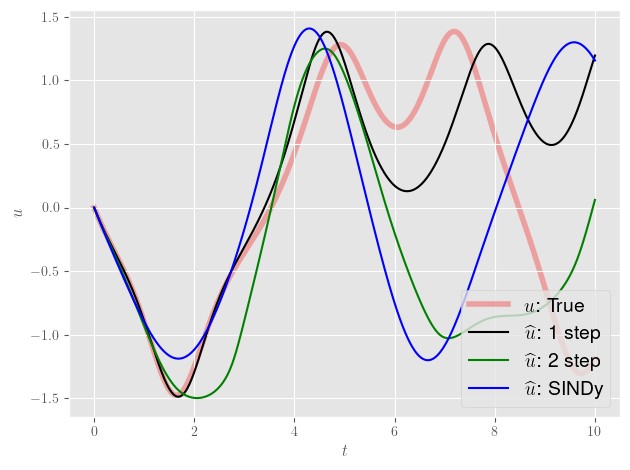

In [22]:
# u predictions
# plt.figure(figsize=(15,5))
tvals = jnp.linspace(t0,t1,5000)
# u true
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
plt.plot(tvals, true, label = '$u$: True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# u pred 1-step
pred1 = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
err_1 = jnp.linalg.norm(true - pred1) / jnp.linalg.norm(true)
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0], c = 'black',ls ='solid',label = r'$\widehat{u}$: 1 step', zorder=1)
# u pred 2-step
pred2 = jax.vmap(ode_init.evaluate)(tvals)[:,0]
err_2 = jnp.linalg.norm(true - pred2) / jnp.linalg.norm(true)
plt.plot(tvals,pred2,label = r'$\widehat{u}$: 2 step', c= 'green', zorder=2)
# u pred SINDy
predSINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
err_SINDy = jnp.linalg.norm(true - predSINDy) / jnp.linalg.norm(true)
plt.plot(tvals,predSINDy,label = r'$\widehat{u}$: SINDy', c= 'blue', zorder=3)
# Plt configs
# plt.title(f'$u$ predictions of 1 step (err: {round(err_1,3)}), 2 step (err: {round(err_2,3)}) and SINDy (err: {round(err_SINDy,2)}) methods with new ICs')
plt.xlabel('$t$')
plt.ylabel('$u$')
plt.legend(fontsize = 14, loc = 'lower right')
plt.tight_layout()
plt.savefig('u_extrapolating.pdf',
            dpi=300,
            format ="pdf"
            )
plt.show()

- Accumulated error plot up to time $t$

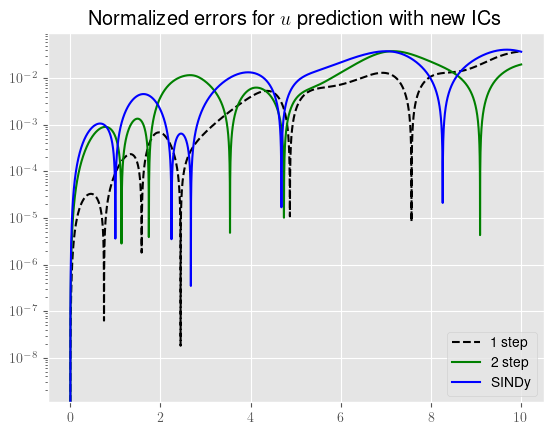

In [20]:
# u errors
# plt.figure(figsize=(15,5))
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = jax.vmap(ode_init.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# SINDy method
pred_SINDy = jax.vmap(ode_SINDy.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_SINDy- true)/jnp.linalg.norm(true),label = 'SINDy', c= 'blue')
# Plot configs
plt.title('Normalized errors for $u$ prediction with new ICs')
plt.yscale('log')
plt.legend()
plt.show()